In [12]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd

from pypcd4 import PointCloud
from scipy.spatial.transform import Rotation
from typing import List, Tuple

import tools.ICP as icp

# Load the pcd from the map.pcd file

In [13]:
def pcd_from_path(file_path: str) -> np.ndarray:
    """
    Loads point clouds from PCD files using the PointCloud library (assumed to be open3d or similar).

    Parameters:
        file_path (str): Path to a .pcd file.

    Returns:
        np.ndarray: Numpy array representing the point cloud, shape [n_points, m_channels].
    
    Raises:
        ValueError: If the file format is not 'pcd'.
        FileNotFoundError: If the file does not exist.
    """
    if not file_path.endswith(".pcd"):
        raise ValueError('Only ".pcd" format is accepted.')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    pc = PointCloud.from_path(file_path)
    return pc.numpy()

# Downsample to voxels

In [14]:
def downsample_voxel(map_array: np.ndarray, voxel_size: float):
    """
    Downsamples a pointcloud using a voxel grid, and provides voxel configurations.

    Args:
    - map_array (np.ndarray): Input point cloud as an Nx3 numpy array.
    - voxel_size (float): Desired voxel size for downsampling.

    Returns:
    - Tuple[np.ndarray, dict]: Downsampled point cloud as an Nx3 numpy array,
                               and a dictionary with voxel configuration details.
    """
    # Convert np array to open3D pointcloud
    map_pcd = o3d.geometry.PointCloud()
    map_pcd.points = o3d.utility.Vector3dVector(map_array)
    
    # Use open3D voxelisation utility with desired voxel_size
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(map_pcd, voxel_size)
    
    # Get coordinates of the voxels that are points of the downsampled grid
    indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()], dtype=float) * voxel_size

    # Calculate voxel configuration details
    max_bound = voxel_grid.get_max_bound()
    min_bound = voxel_grid.get_min_bound()
    voxel_config = {
        'voxel_bounds': {'min': 0, 'max': indices.max(axis=0)},
        'real_bounds': {'min': min_bound, 'max': max_bound}
    }

    # Adjust indices to represent real-world coordinates (center of each voxel)
    indices += min_bound + voxel_size / 2

    return indices, voxel_config

# Plot 2D

In [15]:
def plot_pcd(ax: plt.Axes, points: np.ndarray, **kwargs):
    """
    Plots point cloud data on a given matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the point cloud.
        points (np.ndarray): The point cloud data, expected shape [n_points, at least 2].
        **kwargs: Additional keyword arguments passed to matplotlib scatter plot.

    Raises:
        ValueError: If 'points' does not have the correct dimensions.
    """
    if points.ndim < 2 or points.shape[1] < 2:
        raise ValueError("The 'points' array must have at least two dimensions [n_points, at least 2].")

    return ax.scatter(points[:, 0], points[:, 1], **kwargs)

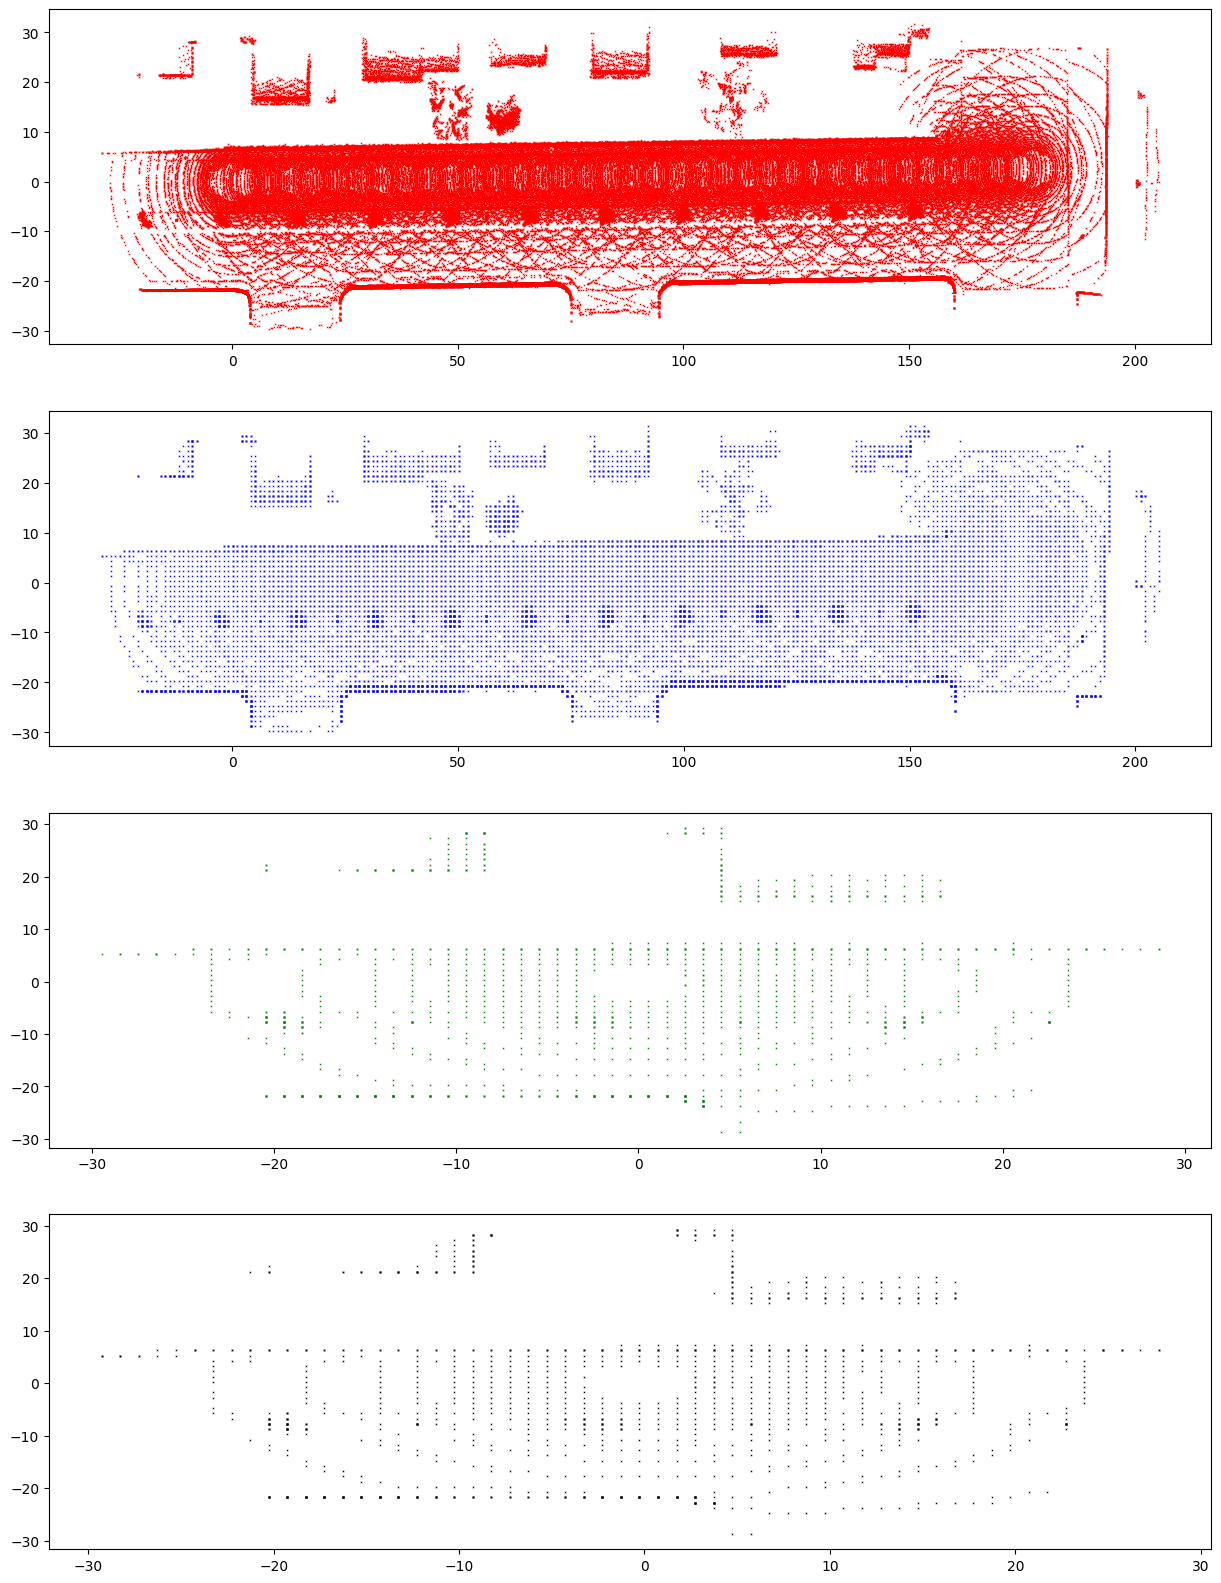

In [16]:
map_array = pcd_from_path("../dataset/map.pcd")

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15, 20))
voxel_map, voxel_config_show = downsample_voxel(map_array, voxel_size=1)

voxel_frames=np.empty(1013, dtype=object)
voxel_config_frames=np.empty(1013, dtype=object)

for frame in range (5,10): #range(0, 1013):
    current_frame_array = pcd_from_path("../dataset/frames/frame_"+str(frame)+".pcd")
    voxel_frames[frame], voxel_config_frames[frame] = downsample_voxel(current_frame_array, voxel_size=1)

plot_pcd(ax1, map_array, color="red", label="Target", marker='x',s=.10)
plot_pcd(ax2, voxel_map, color="blue", label="Target", marker='x',s=.10)

plot_pcd(ax3, voxel_frames[6], color="green", label="Target", marker='x',s=.10)
plot_pcd(ax4, voxel_frames[7], color="black", label="Target", marker='x',s=.10)



# ICP Implementation

In [17]:
from scipy.spatial import KDTree
import time

##### Load PCD File

In [18]:
def pcd_from_path(file_path: str) -> np.ndarray:
    """
    Loads point clouds from PCD files using Open3D.

    Parameters:
        file_path (str): Path to a .pcd file.

    Returns:
        np.ndarray: Numpy array representing the point cloud.
    """
    if not file_path.endswith(".pcd"):
        raise ValueError('Only ".pcd" format is accepted.')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    pcd = o3d.io.read_point_cloud(file_path)
    return np.asarray(pcd.points)

##### Calculate ICP for given point clouds

In [19]:
def configure_icp(source_points, target_points, voxel_size):
    """
    Configures and executes the ICP algorithm to align the source points to the target points.

    Parameters:
        source_points (np.ndarray): Source point cloud as an Nx3 numpy array.
        target_points (np.ndarray): Target point cloud as an Nx3 numpy array.
        voxel_size (float): Voxel size for downsampling.

    Returns:
        np.ndarray: Transformed source points.
        np.ndarray: Final transformation matrix.
    """
    # Convert numpy arrays to Open3D point clouds
    source_pcd = o3d.geometry.PointCloud()
    source_pcd.points = o3d.utility.Vector3dVector(source_points)
    target_pcd = o3d.geometry.PointCloud()
    target_pcd.points = o3d.utility.Vector3dVector(target_points)

    # Downsample the point clouds
    source_down = source_pcd.voxel_down_sample(voxel_size)
    target_down = target_pcd.voxel_down_sample(voxel_size)

    # Estimate normals for the point clouds
    source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))
    target_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=voxel_size * 2, max_nn=30))

    # Perform ICP registration
    icp_result = o3d.pipelines.registration.registration_icp(
        source_down, target_down, voxel_size * 1.5,
        np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=1000)
    )

    # Transform the source point cloud
    source_pcd.transform(icp_result.transformation)
    return np.asarray(source_pcd.points), icp_result.transformation, icp_result.inlier_rmse



##### Plot point-cloud in 3D

In [20]:
def plot_pcd_3d(ax, points, color, label, marker='o', s=1):
    """
    Plots point cloud data on a given matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the point cloud.
        points (np.ndarray): The point cloud data, expected shape [n_points, 3].
        color (str): Color of the points.
        label (str): Label for the plot.
        marker (str): Marker style.
        s (float): Marker size.
    """
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=color, label=label, marker=marker, s=s)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

##### Calculate lateral error

In [21]:
# def calculate_lateral_error(current_location, ground_truth):
#     """
#     Calculate the lateral error between the current location and the ground truth position.
# 
#     Parameters:
#         current_location (np.ndarray): Current location (translation vector) from ICP.
#         ground_truth (np.ndarray): Ground truth position.
# 
#     Returns:
#         float: Lateral error.
#     """
#     lateral_error = np.linalg.norm(current_location - ground_truth)
#     return lateral_error

In [24]:
def calculate_lateral_error(source, target):
    """
    Calculate the lateral error between the source and target point clouds.

    Parameters:
        source (np.ndarray): Transformed source point cloud.
        target (np.ndarray): Target point cloud.

    Returns:
        float: Maximum lateral error.
    """
    tree = KDTree(target)
    _, indices = tree.query(source)
    distances = np.linalg.norm(source - target[indices], axis=1)
    return np.max(distances)

##### Main process

In [ ]:
# # Load ground truth poses
# ground_truth_df = pd.read_csv("../dataset/ground_truth.csv")
# ground_truth_poses = ground_truth_df[[' x', ' y', ' z']].values
# 
# # Main Execution
# map_array = pcd_from_path("../dataset/map.pcd")
# fig = plt.figure(figsize=(15, 20))
# ax1 = fig.add_subplot(411, projection='3d')
# ax2 = fig.add_subplot(412, projection='3d')
# ax3 = fig.add_subplot(413, projection='3d')
# ax4 = fig.add_subplot(414, projection='3d')
# 
# voxel_sizes = [2.0, 1.0, 0.5]  # Multi-scale voxel sizes
# max_iterations = [50, 50, 100]  # Iterations for each scale
# threshold = 0.02  # Set a threshold for ICP
# 
# voxel_map, _ = downsample_voxel(map_array, voxel_sizes[-1])  # Use the finest resolution for error calculation
# 
# transformed_frames = []
# lateral_errors = []
# compute_times = []
# for frame in range(0, 1013):  # For demonstration, using a smaller range
#     print(f"Processing frame {frame}")
#     current_frame_array = pcd_from_path(f"../dataset/frames/frame_{frame}.pcd")
#     voxel_frame, _ = downsample_voxel(current_frame_array, voxel_sizes[-1])  # Use the finest resolution
#     
#     # Perform Multi-Scale ICP localization
#     start_time = time.time()
#     transformed_frame, transformation, current_location, rmse = multi_scale_icp(voxel_frame, voxel_map, voxel_sizes, max_iterations, threshold)
#     end_time = time.time()
#     
#     # Compute performance metrics
#     lateral_error = calculate_lateral_error(current_location, ground_truth_poses[frame])
#     compute_time = end_time - start_time
#     
#     lateral_errors.append(lateral_error)
#     compute_times.append(compute_time)
#     
#     transformed_frames.append(transformed_frame)
# 
# # Plot results
# plot_pcd_3d(ax1, map_array, color="red", label="Original Map", marker='x', s=0.1)
# plot_pcd_3d(ax2, voxel_map, color="blue", label="Voxelized Map", marker='x', s=0.1)
# plot_pcd_3d(ax3, transformed_frames[0], color="green", label="Transformed Frame 0", marker='x', s=0.1)
# plot_pcd_3d(ax4, transformed_frames[1], color="black", label="Transformed Frame 1", marker='x', s=0.1)
# 
# plt.show()
# 
# # Evaluate performance
# max_lateral_error = np.max(lateral_errors)
# average_compute_time = np.mean(compute_times)
# 
# print(f"Maximum Lateral Error: {max_lateral_error:.2f} meters")
# print(f"Average Compute Time: {average_compute_time:.2f} seconds")
# 
# # Ensure lateral error is within acceptable limits
# if max_lateral_error <= 1.2:
#     print("Lateral error is within acceptable limits.")
# else:
#     print("Lateral error exceeds acceptable limits!")

Processing frame 0
Current location: [ 0.02669946 -0.02438768  0.10431816]
Processing frame 1
Current location: [0.057277   0.13331144 0.1237178 ]
Processing frame 2
Current location: [-0.1817229   0.07625105  0.11528446]
Processing frame 3
Current location: [0.03060942 0.0528988  0.1152636 ]
Processing frame 4
Current location: [0.32613907 0.06441266 0.10854752]
Processing frame 5
Current location: [-0.41927149  0.08449916  0.11416506]
Processing frame 6
Current location: [-0.34215872  0.06589884  0.11273598]
Processing frame 7
Current location: [0.35841718 0.08465608 0.11442483]
Processing frame 8
Current location: [-0.05942604  0.06715848  0.11490738]
Processing frame 9
Current location: [0.30248484 0.08272612 0.1139773 ]
Processing frame 10
Current location: [0.02666912 0.06552039 0.11845413]
Processing frame 11
Current location: [-0.25298639  0.05172108  0.10946544]
Processing frame 12
Current location: [-0.35091698  0.06550535  0.11354419]
Processing frame 13
Current location: [0

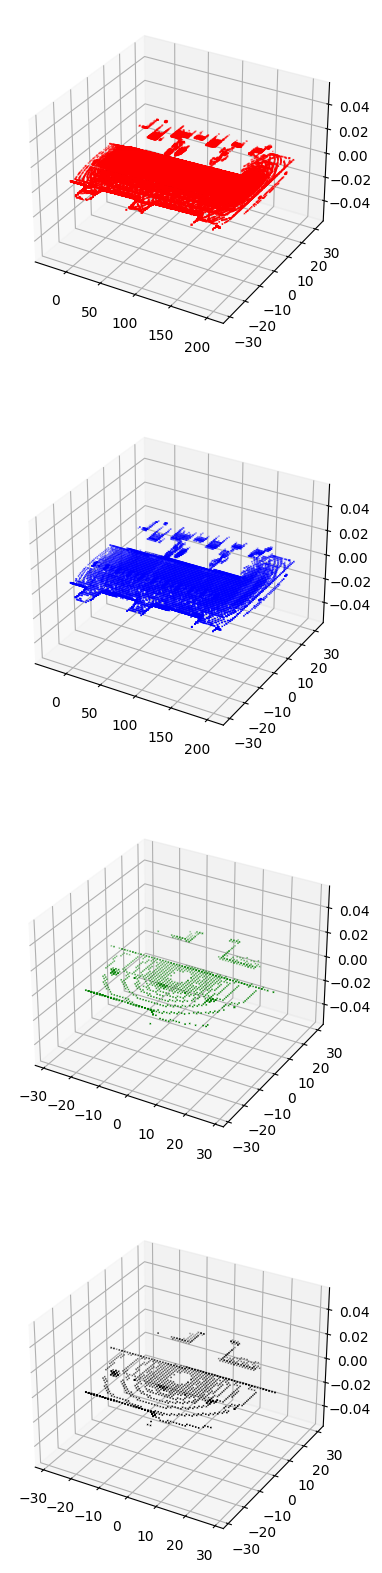

Maximum Lateral Error: 8.88 meters
Average Compute Time: 0.02 seconds
Lateral error exceeds acceptable limits!


In [25]:
# Load ground truth poses
ground_truth_df = pd.read_csv("../dataset/ground_truth.csv")
ground_truth_poses = ground_truth_df[[' x', ' y', ' z']].values

# Main Execution
map_array = pcd_from_path("../dataset/map.pcd")
fig = plt.figure(figsize=(15, 20))
ax1 = fig.add_subplot(411, projection='3d')
ax2 = fig.add_subplot(412, projection='3d')
ax3 = fig.add_subplot(413, projection='3d')
ax4 = fig.add_subplot(414, projection='3d')

voxel_size = 0.99
voxel_map, _ = downsample_voxel(map_array, voxel_size)  # Get only the downsampled point cloud

transformed_frames = []
lateral_errors = []
compute_times = []
current_location_x = 0
current_location_y = 0
current_location_z = 0

# TODO: Switch to full range before submitting -> range(0, 1013)
for frame in range(0, 100):  # For demonstration, using a smaller range
    print(f"Processing frame {frame}")
    current_frame_array = pcd_from_path(f"../dataset/frames/frame_{frame}.pcd")
    voxel_frame, _ = downsample_voxel(current_frame_array, voxel_size)  # Get only the downsampled point cloud
    
    # Perform ICP localization
    start_time = time.time()
    transformed_frame, transformation, rmse = configure_icp(voxel_frame, voxel_map, voxel_size)
    end_time = time.time()
    
    # current_location = current_location + transformation[:3, 3]
    # TODO: From my understanding, the assumed location of the car can be extracted from the transformation
    current_location = transformation[:3, 3]
    print(f"Current location: {current_location}")
    # current_location_x += current_location[0]
    # current_location_y += current_location[1]
    # current_location_z += current_location[2]
    # print(f"Current location: {np.array([current_location_x, current_location_y, current_location_z])}")
    
    # Compute performance metrics
    # TODO: From my understanding, we should calculate lateral error based on the ground truth pose
    lateral_error = calculate_lateral_error(transformed_frame, voxel_map)
    # lateral_error = calculate_lateral_error(current_location, ground_truth_poses[frame])
    compute_time = end_time - start_time
    
    lateral_errors.append(lateral_error)
    compute_times.append(compute_time)
    
    transformed_frames.append(transformed_frame)

# Plot results
plot_pcd(ax1, map_array, color="red", label="Original Map", marker='x', s=0.1)
plot_pcd(ax2, voxel_map, color="blue", label="Voxelized Map", marker='x', s=0.1)
plot_pcd(ax3, transformed_frames[0], color="green", label="Transformed Frame 0", marker='x', s=0.1)
plot_pcd(ax4, transformed_frames[1], color="black", label="Transformed Frame 1", marker='x', s=0.1)

plt.show()

# Evaluate performance
max_lateral_error = np.max(lateral_errors)
average_compute_time = np.mean(compute_times)

print(f"Maximum Lateral Error: {max_lateral_error:.2f} meters")
print(f"Average Compute Time: {average_compute_time:.2f} seconds")

# Ensure lateral error is within acceptable limits
if max_lateral_error <= 1.2:
    print("Lateral error is within acceptable limits.")
else:
    print("Lateral error exceeds acceptable limits!")

# NDT Implementation